# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

# 1. Pricing the Callable Bond

### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`

The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.

`Reference` bonds for a forward price.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money. Thus, for the purposes of this analysis, we consider the reference bonds as non-callable bonds.

These reference bonds are analyzed in optional problems at the end, but mostly you will focus on the `callable` bond.

In [1]:
FILE_BOND = '../data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = '../data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'
KEY_REF_T1 = 'FHLMC 0.97 01/28/28'
KEY_REF_T2 = 'FHLMC 1 1/4 01/29/30'

### Bond Info

In [126]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.optimize import brentq

info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


### Quoted Values

In [3]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.95,4.96,4.96
Clean Price,90.14,85.11,99.89
Dirty Price,90.19,85.16,100.09
Accrued Interest,0.04,0.05,0.20
YTM Call,54.24,85.40,4.45
YTM Maturity,4.57,4.65,4.43
Duration,2.92,4.81,4.50
Modified Duration,2.85,4.70,4.40


### Discount Curves

In [19]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


***

### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

For now, calculate the price of the `callable` bond as if it were non-callable. We refer to this as the `hypothetical` bond.

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
TTM,2.954141,4.958248,4.95551
Clean Price,90.144,85.1095,99.893
Dirty Price,90.187111,85.161583,100.089
Accrued Interest,0.043111,0.052083,0.196
YTM Call,54.240686,85.395782,4.448321
YTM Maturity,4.572927,4.646847,4.433845
Duration,2.917203,4.806058,4.496738
Modified Duration,2.851993,4.696929,4.399211


In [67]:
def price_call(q_df, bond_df, disc_df, call=True):
    df = q_df.copy()
    df.loc['Cpn Rate'] = bond_df.loc['Cpn Rate']
    def col_price_call(columns, disc_df, call=call):
        d_df = disc_df.copy()
        ttm_val = round((columns.loc['TTM'] * 2) / 2)
        cpn = columns.loc['Cpn Rate'] / 2
        oas = columns.loc['OAS Spread']
        if call:
            d_df['spot rate'] = d_df['spot rate'] + oas / 10000
            # oas is in bps space
            d_df['discount'] = np.exp(- d_df['spot rate'] * d_df.index)
        
        ttm_disc_df = d_df[d_df.index <= ttm_val]
        price = ttm_disc_df['discount'].sum() * cpn + ttm_disc_df['discount'].iloc[-1]

        return price
    
    if call:
        name = 'Callable implied price'
    else:
        name = 'Non-Callable implied price'

    df.loc[name] = df.apply(lambda col: col_price_call(col, disc_df), axis=0)

    return df
        

# With OAS discounting

In [68]:
price_call(quotes, info, discs)

# check last row

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
TTM,2.954141,4.958248,4.95551
Clean Price,90.144,85.1095,99.893
Dirty Price,90.187111,85.161583,100.089
Accrued Interest,0.043111,0.052083,0.196
YTM Call,54.240686,85.395782,4.448321
YTM Maturity,4.572927,4.646847,4.433845
Duration,2.917203,4.806058,4.496738
Modified Duration,2.851993,4.696929,4.399211


# Without OAS discounting, so non-callable

In [69]:
price_call(quotes, info, discs, call=False)

# check last row

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
TTM,2.954141,4.958248,4.95551
Clean Price,90.144,85.1095,99.893
Dirty Price,90.187111,85.161583,100.089
Accrued Interest,0.043111,0.052083,0.196
YTM Call,54.240686,85.395782,4.448321
YTM Maturity,4.572927,4.646847,4.433845
Duration,2.917203,4.806058,4.496738
Modified Duration,2.851993,4.696929,4.399211


### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.

In [70]:
# discount rate on the date closest to the expiries should be used

init_date = quotes[KEY_CALLABLE].loc['Date Quoted']
option_date = info[KEY_CALLABLE].loc['Date of First Possible Call']

ttm_option = round((option_date - init_date).days / 365.25)
# given the bond is issued 1/28/2025, it is reasonable to assume that we observe coupons on reasonable dates (exact cpn dates)

adj_discs = discs[discs.index >= ttm_option].copy()
adj_discs.index = adj_discs.index - ttm_option

adj_discs['discount'] = adj_discs['discount'] / adj_discs['discount'].iloc[0]
adj_discs['spot rate'] = - np.log(adj_discs['discount']) / adj_discs.index

adj_ttm = 2

less_discs = adj_discs[adj_discs.index <= adj_ttm]
c_cpn = info[KEY_CALLABLE].loc['Cpn Rate']

forward_price = less_discs['discount'].sum() * c_cpn + less_discs['discount'].iloc[-1]

forward_price


1.1337053126783805

### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.

In [71]:
# using modified duration here probably better
# use forward rate from year 3 to 5?

f_rate = less_discs['spot rate'].iloc[-1]
vol_rate = quotes[KEY_CALLABLE].loc['Implied Vol']
dur = quotes[KEY_CALLABLE].loc['Modified Duration']

vol_fwd_price = dur * vol_rate * f_rate / 10000

# value in % space assuming vol of rates is in bps
vol_fwd_price

0.00042717961725817873

### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.

In [72]:
def black_bond_call(discount_f, fwd_price, vol_fwd_price, tt_call, strike_price=1):
    sigma_t = vol_fwd_price * np.sqrt(tt_call)
    d1 = (np.log(fwd_price / strike_price) + 0.5 * sigma_t ** 2) / sigma_t
    d2 = d1 - sigma_t

    call_price = discount_f * (fwd_price * norm.cdf(d1) - strike_price * norm.cdf(d2))

    return call_price    

In [73]:
discount = discs.loc[3]['discount']
# forward_price is calced above
# vol_fwd_price is calced above
# time to call is 3 years

# the value calculated here assumes a base price of 1

call_val = black_bond_call(discount, forward_price, vol_fwd_price, 3)

call_val

0.11820673516939678

In [74]:
non_df = price_call(quotes, info, discs, call=False)

backed_out_price = 100 * (non_df[KEY_CALLABLE].loc['Non-Callable implied price'] - call_val)

actual_price = non_df[KEY_CALLABLE].loc['Clean Price']

print(backed_out_price)
print(actual_price)

89.40646949249744
99.893


## 1.4 solution
My calculated price is relatively far off. There should be some errors in previous calculations.

### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?

In [75]:
def bond_ytm(price, cpn_rate, ttm, freq=2, notional=100):
    cpn_payment = (cpn_rate * notional) / freq
    tot_periods = ttm * freq

    def bond_price_eq(y):
        return sum([cpn_payment / (1 + y/freq) ** (t) for t in range(1, tot_periods + 1)]) + \
        notional / (1 + y/freq) ** tot_periods - price

    ytm_guess = 0.05

    ytm_sol = fsolve(bond_price_eq, ytm_guess)[0] 

    return ytm_sol * freq   

In [76]:
hyp_price = non_df[KEY_CALLABLE].loc['Non-Callable implied price'] * 100
# use c_cpn
# ttm = 5

ytm_nc = bond_ytm(hyp_price, c_cpn, 5)

#ytm never called
ytm_nc

0.08271602566257309

In [77]:
# if it is always called, the bond essentially matures at ttm = 3
c_discs = discs[discs.index <= 3].copy()
called_price = (c_discs['discount'].sum() * c_cpn + c_discs['discount'].iloc[-1]) * 100

called_price

113.02940099774301

In [78]:
ytm_c = bond_ytm(called_price, c_cpn, 3)

# ytm called
ytm_c

0.001242840346347309

### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.

### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.

### 1.8. Optional

Calculate the forward price of the `hypothetical` bond, but try doing so by using the `reference` bonds to calculate the forward price.
* The prices of these reference bonds would be discount factors, and we simply take the ratio.
* However, the coupons of the bonds do not align, so you need to adjust for this fact.

### 1.9. Optional

Analyze what we have called the `reference` bonds as `callable` bonds. 

Calculate its value, YTMs, duration, and OAS.

***

# 2. Pricing Floors

### Data

The file `data/cap_curves_2025-01-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

In [90]:
path2 = '../data/cap_curves_2025-01-31.xlsx'
data2 = pd.read_excel(path2).set_index('tenor')

data2.columns

Index(['swap rates', 'spot rates', 'discounts', 'forwards', 'flat vols',
       'fwd vols'],
      dtype='object')

### 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency

In [105]:
def floorlet_price(discount_factor, forward_rate, strike, vol_fwd, ttm, notional=100, freq=4):
    try:
        sigma_t = vol_fwd * np.sqrt(ttm - 1/freq)
        d1 = np.log(forward_rate / strike) / sigma_t + 0.5 * sigma_t
        d2 = d1 - sigma_t

        return notional / freq * discount_factor * (strike * norm.cdf(-d2) - forward_rate * norm.cdf(-d1))
    except Exception:
        return np.NaN

In [106]:
data2['floorlet'] = data2.apply(lambda row: np.NaN if row.name == data2.index[0] else floorlet_price(
    discount_factor=row['discounts'],
    forward_rate=row['forwards'],
    strike=row['swap rates'],
    vol_fwd=row['fwd vols'],
    ttm=row.name  # Ensure correct ttm usage
), axis=1)

In [107]:
# floorlet 3
data2['floorlet'].iloc[11]

0.14631026173528633

### 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

In [108]:
floor3 = data2[data2.index <= 3]['floorlet'].sum()

print(floor3)

1.2205382543415577


***

# 3. Stripping Caps

### Data

Continue with the file `data/cap_curves_2025-01-31.xlsx`.

### 3.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [109]:
def caplet_price(discount_factor, forward_rate, strike, vol_fwd, ttm, notional=100, freq=4):
    try:
        sigma_t = vol_fwd * np.sqrt(ttm - 1/freq)
        d1 = np.log(forward_rate / strike) / sigma_t + 0.5 * sigma_t
        d2 = d1 - sigma_t

        return notional / freq * discount_factor * (forward_price * norm.cdf(d1) - strike * norm.cdf(d2))
    except Exception:
        return np.NaN

In [120]:

def cap_price(data):
    caps = []

    for i in data.index:
        if i == 0.25:
            continue  # Skip first row

        df = data[data.index <= i].copy()  # Use .copy() to avoid modifying original data

        df['caplet'] = df.apply(lambda row: np.NaN if row.name == data.index[0] else caplet_price(
            discount_factor=row['discounts'],
            forward_rate=row['forwards'],
            strike=row['swap rates'],
            vol_fwd=row['flat vols'],  # Ensure this matches caplet_price() parameter
            ttm=row.name
        ), axis=1)

        caps.append(df['caplet'].sum())  # Store sum of caplets for cap price

    # Ensure correct length by padding with NaN for the first skipped row
    cap_series = pd.Series(caps, index=data.index[1:])  # Align with the remaining index
    data['cap'] = cap_series.reindex(data.index)  # Align index to avoid length mismatch

    return data


In [121]:
data2 = cap_price(data2)

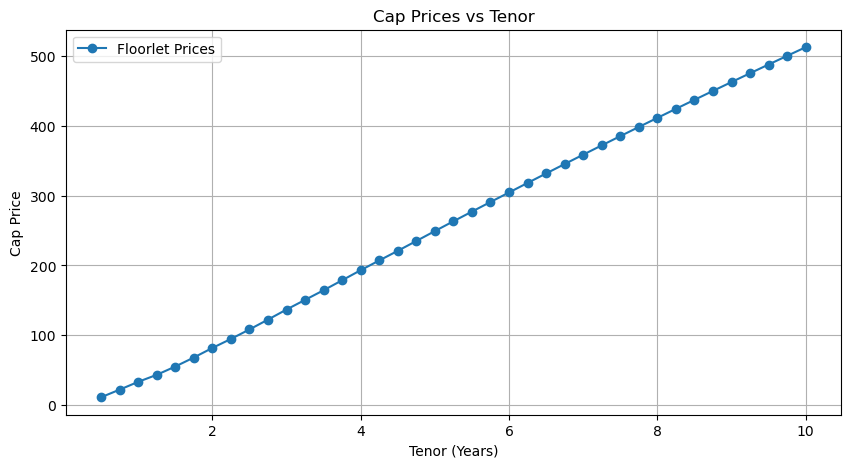

In [123]:
tenors = data2.index  # X-axis (tenor values)
cap_prices = data2['cap']  # Y-axis (floorlet prices)

# Plot 1: Floorlet Prices
plt.figure(figsize=(10, 5))
plt.plot(tenors, cap_prices, marker='o', linestyle='-', label="Floorlet Prices")
plt.xlabel("Tenor (Years)")
plt.ylabel("Cap Price")
plt.title("Cap Prices vs Tenor")
plt.legend()
plt.grid(True)
plt.show()

### 3.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

***

In [125]:
data2['cap'].iloc[0] = 0

data2['caplet'] = data2['cap'] - data2['cap'].shift()

data2

C:\Users\vince\AppData\Local\Temp\ipykernel_27828\1783082983.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data2['cap'].iloc[0] = 0


,swap rates,spot rates,discounts,forwards,flat vols,fwd vols,floorlet,caplet,cap
tenor,,,,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN,NaN,NaN,0.000000
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500,0.027181,11.196847,11.196847
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478,0.048129,10.874046,22.070894
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562,0.066733,11.179875,33.250769
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138,0.112301,10.045671,43.296440
1.50,0.040142,0.040117,0.941881,0.038514,0.180856,0.239613,0.119010,11.887077,55.183516
1.75,0.039966,0.039940,0.932816,0.038873,0.197446,0.254106,0.126866,12.905895,68.089411
2.00,0.039902,0.039877,0.923708,0.039440,0.209941,0.261605,0.131264,13.705757,81.795168
2.25,0.039717,0.039688,0.914976,0.038173,0.219090,0.263323,0.149992,12.891459,94.686628


In [127]:
def solve_forward_vol(caplet_price_obs, discount_factor, forward_rate, strike, ttm, notional=100, freq=4):
    def objective(vol_fwd):
        return caplet_price(discount_factor, forward_rate, strike, vol_fwd, ttm, notional, freq) - caplet_price_obs

    try:
        # Solve for vol_fwd using a root-finding method (Brent’s method)
        vol_fwd_solved = brentq(objective, 1e-6, 2.0)  # Bounds: (low=0.000001, high=2.0)
        return vol_fwd_solved
    except ValueError:
        return np.NaN  # If the root-finding fails, return NaN

# Apply to DataFrame: Solve for forward volatilities using caplet values
data2['solved_fwd_vols'] = data2.apply(lambda row: np.NaN if row.name == data2.index[0] else solve_forward_vol(
    caplet_price_obs=row['caplet'],  # Observed caplet price
    discount_factor=row['discounts'],
    forward_rate=row['forwards'],
    strike=row['swap rates'],
    ttm=row.name
), axis=1)

In [129]:
data2[['cap', 'caplet']]

,cap,caplet
tenor,,
0.25,0.000000,NaN
0.50,11.196847,11.196847
0.75,22.070894,10.874046
1.00,33.250769,11.179875
1.25,43.296440,10.045671
1.50,55.183516,11.887077
1.75,68.089411,12.905895
2.00,81.795168,13.705757
2.25,94.686628,12.891459


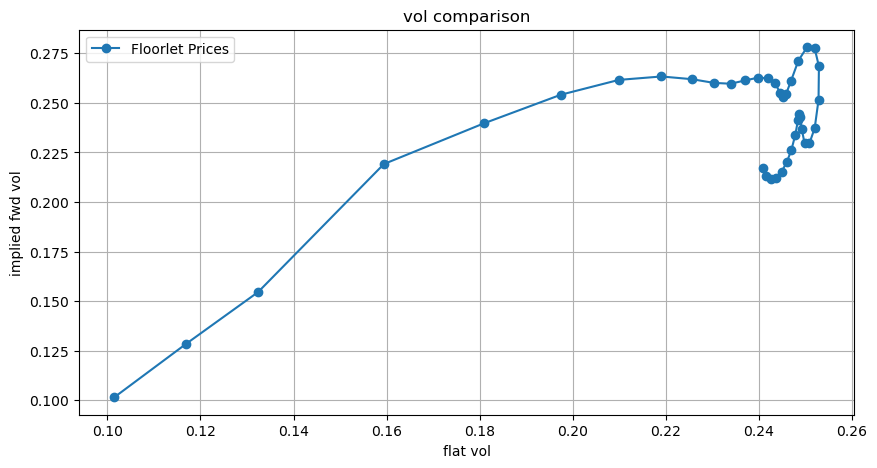

In [132]:

plt.figure(figsize=(10, 5))
plt.plot(data2['flat vols'], data2['fwd vols'], marker='o', label="Floorlet Prices")
plt.xlabel("flat vol")
plt.ylabel("implied fwd vol")
plt.title("vol comparison")
plt.legend()
plt.grid(True)
plt.show()